##### Copyright 2022 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with a Transformer and Keras

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/transformer">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/transformer.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to create and train a [sequence-to-sequence](https://developers.google.com/machine-learning/glossary#sequence-to-sequence-task){:.external} [Transformer](https://developers.google.com/machine-learning/glossary#Transformer){:.external} model to translate [Portuguese into English](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en){:.external}. Most of the components are built with high-level Keras and low-level TensorFlow APIs. The Transformer was originally proposed in ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} by Vaswani et al. (2017).

Transformers are deep neural networks primarily based on various types of [attention](https://developers.google.com/machine-learning/glossary#attention){:.external} mechanisms and [feed-forward networks](https://www.tensorflow.org/guide/keras/sequential_model). The Transformer in this example uses [self-attention](https://developers.google.com/machine-learning/glossary#self-attention){:.external}. Attention allows Transformers to attend different positions of the input sequence. For example, when working with natural language, the models can make use of the surrounding text to predict a token.

As explained in the [Google AI Blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html){:.external}:

> Neural networks for machine translation typically contain an encoder reading the input sentence and generating a representation of it. A decoder then generates the output sentence word by word while consulting the representation generated by the encoder. The Transformer starts by generating initial representations, or embeddings, for each word... Then, using self-attention, it aggregates information from all of the other words, generating a new representation per word informed by the entire context, represented by the filled balls. This step is then repeated multiple times in parallel for all words, successively generating new representations.

<img src="https://www.tensorflow.org/images/tutorials/transformer/apply_the_transformer_to_machine_translation.gif" alt="Applying the Transformer to machine translation">

Figure 1: Applying the Transformer to machine translation. Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

In this tutorial you will:

- Load the data with [TensorFlow Datasets](https://tensorflow.org/datasets).
- Define tokenization functions.
- Prepare `tf.data` pipelines.
- Implement positional encoding and [embedding](https://developers.google.com/machine-learning/glossary#embeddings){:.external} to help learn word ordering.
- Implement the encoder-decoder Transformer:
  - Create a point-wise feed-forward network with Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) API and `tf.keras.layers.Dense` layers.
  - Implement [encoder](https://developers.google.com/machine-learning/glossary#encoder){:.external} and [decoder](https://developers.google.com/machine-learning/glossary#decoder){:.external} layers by subclassing `tf.keras.layers.Layer`.
  - Define the encoder and decoder, which are made up of `tf.keras.layers.MultiHeadAttention` for self-attention layers, as well as `tf.keras.layers.LayerNormalization` and `tf.keras.layers.Dense`.
  - Put the encoder and the decoder together to create the Transformer model.
- Train the Transformer.
- Generate translations.

Most of the Transformer components in this tutorial use the built-in APIs like `tf.keras.layers.MultiHeadAttention`.

To get the most out of this tutorial, it helps if you know about [the basics of text generation](./text_generation.ipynb) and [attention mechanisms](./nmt_with_attention.ipynb).

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" alt="Attention heatmap">

Figure 2: Visualized attention weights that you can generate at the end of this tutorial.

## Why Transformers are significant

- Transformers excel at modeling sequential data, such as natural language.
- Unlike the [recurrent neural networks (RNNs)](./text_generation.ipynb), such as [LSTMs](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.676.4320&rep=rep1&type=pdf){:.external}, Transformers can be more computationally efficient and parallelizable across several specialized hardware, like GPUs and TPUs. One of the main reasons is that Transformers replaced recurrence with attention, and computations can happen simultaneously. Layer outputs can be calculated in parallel, instead of a series like an RNN.
- Unlike [RNNs](https://www.tensorflow.org/guide/keras/rnn) (like [seq2seq, 2014](https://arxiv.org/abs/1409.3215){:.external}) or [convolutional neural networks (CNNs)](https://www.tensorflow.org/tutorials/images/cnn) (for example, [ByteNet](https://arxiv.org/abs/1610.10099){:.external}), Transformers are able to capture distant or long-range contexts and dependencies in the data between distant positions in the input or output sequences. Thus, longer connections can be learned. Attention allows each location to have access to the entire input at each layer, while in RNNs and CNNs, the information needs to pass through many processing steps to move a long distance, which makes it harder to learn.
- Transformers make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8){:.external}).

<img src="https://www.tensorflow.org/images/tutorials/transformer/encoder_self_attention_distribution.png" width="800" alt="Encoder self-attention distribution for the word it from the 5th to the 6th layer of a Transformer trained on English-to-French translation">

Figure 3: The encoder self-attention distribution for the word “it” from the 5th to the 6th layer of a Transformer trained on English-to-French translation (one of eight attention heads). Source: [Google AI Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html).

## Setup

Begin by installing [TensorFlow Datasets](https://tensorflow.org/datasets) for loading the dataset and [TensorFlow Text](https://www.tensorflow.org/text) for text preprocessing:

In [3]:
# Install the nightly version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!pip uninstall -y -q tensorflow keras estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text-nightly==2.11.0.dev20220817

     |████████████████████████████████| 5.9 MB 13.2 MB/s 


In [4]:
!pip install -U -q tf-nightly==2.11.0.dev20220817

     |████████████████████████████████| 582.0 MB 13 kB/s 
     |████████████████████████████████| 439 kB 67.6 MB/s 
     |████████████████████████████████| 5.9 MB 42.1 MB/s 
     |████████████████████████████████| 1.7 MB 43.1 MB/s 


Import the necessary modules:

In [5]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

## Download the dataset

Use TensorFlow Datasets to load the [Portuguese-English translation dataset](https://www.tensorflow.org/datasets/catalog/ted_hrlr_translate#ted_hrlr_translatept_to_en){:.external} from the TED Talks Open Translation Project. This dataset contains approximately 52,000 training, 1,200 validation and 1,800 test examples.

In [6]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en',
                               with_info=True,
                               as_supervised=True)

train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/51785 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteR4BVDA/ted_hrlr_translate-train.tf…

Generating validation examples...:   0%|          | 0/1193 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteR4BVDA/ted_hrlr_translate-validati…

Generating test examples...:   0%|          | 0/1803 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteR4BVDA/ted_hrlr_translate-test.tfr…

Dataset ted_hrlr_translate downloaded and prepared to ~/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


The `tf.data.Dataset` object returned by TensorFlow Datasets yields pairs of text examples:

In [7]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  print('> Examples in Portuguese:')
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  print()

  print('> Examples in English:')
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

> Examples in Portuguese:
e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

> Examples in English:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


## Load the tokenizer

Now that you have loaded the dataset, you need to tokenize the text, so that each element is represented as a [token](https://developers.google.com/machine-learning/glossary#token){:.external} or token ID (a numeric representation).

Tokenization is the process of breaking up a sequence, such as a text, into tokens, for each element in that sequence. Commonly, these tokens are words, characters, numbers, subwords, and/or punctuation. The beginning of sentences and end of sentences are typically also marked by tokens IDs, such as `'[START]'` and `'[END]'`.

Tokenization can be done in various ways. For example, for a text sequence of `'how are you'`, you can apply:

- Word-level tokenization, such as `'how'`, `'are'`, `'you'`.
- Character-level tokenization, such as `'h'`, `'o'`, `'w'`, `'a'`, and so on. This would result in a much longer sequence length compared with the previous method.
- Subword tokenization, which can take care of common/recurring word parts, such as `'ing'` and `'tion'`, as well as common words like `'are'` and `'you'`.

To learn more about tokenization, visit [this guide](https://www.tensorflow.org/text/guide/tokenizers).

### Subword tokenizer

This tutorial uses a popular [subword tokenizer](https://www.tensorflow.org/text/guide/subwords_tokenizer) implementation, which builds subword tokenizers (`text.BertTokenizer`) optimized for the dataset and exports them in a TensorFlow `saved_model` format.

Download, extract, and import the `saved_model`:

In [8]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [9]:
tokenizers = tf.saved_model.load(model_name)

The `tf.saved_model` contains two text tokenizers, one for English and one for Portuguese. Both have the same methods:

In [10]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

The `tokenize` method converts a batch of strings to a padded-batch of token IDs. This method splits punctuation, lowercases and unicode-normalizes the input before tokenizing. That standardization is not visible here because the input data is already standardized.

In [11]:
print('> This is a batch of strings:')
for en in en_examples.numpy():
  print(en.decode('utf-8'))

> This is a batch of strings:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [12]:
encoded = tokenizers.en.tokenize(en_examples)

print('> This is a padded-batch of token IDs:')
for row in encoded.to_list():
  print(row)

> This is a padded-batch of token IDs:
[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


The `detokenize` method attempts to convert these token IDs back to human-readable text: 

In [13]:
round_trip = tokenizers.en.detokenize(encoded)

print('> This is human-readable text:')
for line in round_trip.numpy():
  print(line.decode('utf-8'))

> This is human-readable text:
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


The lower level `lookup` method converts from token-IDs to token text:

In [14]:
print('> This is the text split into tokens:')
tokens = tokenizers.en.lookup(encoded)
tokens

> This is the text split into tokens:


<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

The output demonstrates the "subword" aspect of the subword tokenization.

For example, the word `'searchability'` is decomposed into `'search'` and `'##ability'`, and the word `'serendipity'` into `'s'`, `'##ere'`, `'##nd'`, `'##ip'` and `'##ity'`.

Note that the tokenized text includes `'[START]'` and `'[END]'` tokens.

The distribution of tokens per example in the dataset is as follows:

In [15]:
lengths = []

for pt_examples, en_examples in train_examples.batch(1024):
  pt_tokens = tokenizers.en.tokenize(pt_examples)
  lengths.append(pt_tokens.row_lengths())
  
  en_tokens = tokenizers.en.tokenize(en_examples)
  lengths.append(en_tokens.row_lengths())
  print('.', end='', flush=True)

...................................................

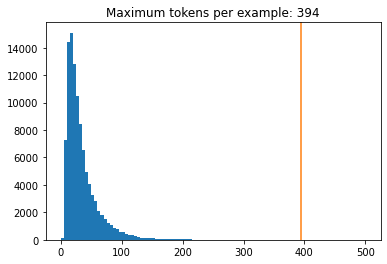

In [16]:
all_lengths = np.concatenate(lengths)

plt.hist(all_lengths, np.linspace(0, 500, 101))
plt.ylim(plt.ylim())
max_length = max(all_lengths)
plt.plot([max_length, max_length], plt.ylim())
plt.title(f'Maximum tokens per example: {max_length}');

### Create tokenizer functions

This section shows how to define custom functions for transforming/tokenizing the text in the dataset into tokens. You will need these for building an input pipeline suitable for training.

The following function drops examples longer than the maximum number of tokens (`MAX_TOKENS`). Without limiting the size of sequences, the performance may be negatively affected.

In [17]:
MAX_TOKENS = 128

def filter_max_tokens(pt, en):
  num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
  return num_tokens < MAX_TOKENS

Next, define a function that tokenizes the batches of raw text:

In [18]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

## Set up a data pipeline with `tf.data`

In this step, you set up a `tf.data` pipeline that tokenizes that dataset using your `tokenize_pairs()` function with `Dataset.map`. Make sure to use buffered prefetching `Dataset.prefetch`, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the dataset elements in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the `tf.data` API](https://www.tensorflow.org/guide/data_performance.ipynb) guide.

The `tf.data` input pipeline that tokenizes/processes, shuffles and batches the data looks as follows:

In [19]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [20]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(buffer_size=tf.data.AUTOTUNE))

# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

## Embedding

Now that your sequences of text are converted into sequences of tokens, both the input language tokens (Portuguese) and target language tokens (English) have to go through embedding layers. Token embeddings learn to represent each element as a vector/tensor. Embeddings represent tokens in a d-dimensional space where tokens with similar meaning will be closer to each other.

Converting tokens into embedding tensors is done with the built-in `tf.keras.layers.Embedding` layer, which is shown in the encoder/decoder sections of this tutorial.

Next, the input embeddings need to be added with the positional encoding, which is covered in the next section.

## Positional encoding

Positional encodings are added to the embeddings to give the model some information about the relative position of the tokens in the sentence. Now the model can _learn_ to recognize the word order.

This section shows how to implement positional encoding.

Attention layers see their input as a set of vectors, with no sequential order. As discussed earlier in the tutorial, the model doesn't contain any recurrent or convolutional layers.

Without positional information the order of elements would be unknown. This would be similar to a [bag of words](https://developers.google.com/machine-learning/glossary#bag-of-words){:.external}, where, for instance, `how are you`, `how you are`, `you how are`, and so on, are represented identically.

The embeddings on their own do not encode the relative position of tokens in a sentence. Therefore, after adding the positional encoding, tokens are closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

The formula for calculating the positional encoding (implemented in Python below) is as follows:

$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [21]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [22]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # Apply the sine function to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # Apply the cosine function to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

Test the positional encoding function:

(1, 2048, 512)


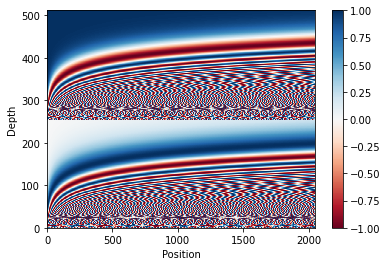

In [23]:
# Set the inner-layer dimensionality and the input/output dimensionality.
n, d = 2048, 512

pos_encoding = positional_encoding(position=n, d_model=d)

# Check the shape.
print(pos_encoding.shape)

pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot.
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

# Plot the dimensions.
plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Before you start putting together the Transformer, define a function for the point-wise feed-forward network that you'll be reusing later.

## Create a point-wise feed-forward network

A point-wise feed-forward network consists of two linear layers (`tf.keras.layers.Dense`) with a ReLU activation in-between:

In [24]:
def point_wise_feed_forward_network(
  d_model, # Input/output dimensionality.
  dff # Inner-layer dimensionality.
  ):

  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # Shape `(batch_size, seq_len, dff)`.
      tf.keras.layers.Dense(d_model)  # Shape `(batch_size, seq_len, d_model)`.
  ])

Test the function:

In [25]:
sample_ffn = point_wise_feed_forward_network(512, 2048)

# Print the shape.
print(sample_ffn(tf.random.uniform((64, 50, 512))).shape)

(64, 50, 512)


Having loaded the data, it's time to create the Transformer model.

## Build the Transformer

The Transformer model in this tutorial follows the same general pattern as a standard [sequence-to-sequence](https://www.tensorflow.org/text/tutorials/nmt_with_attention) model with an [encoder](https://developers.google.com/machine-learning/glossary#encoder){:.external} and a [decoder](https://developers.google.com/machine-learning/glossary#decoder){:.external}.

<img src="https://www.tensorflow.org/images/tutorials/transformer/standard_transformer_architecture.png" alt="Standard transformer architecture">

Figure 4: The standard Transformer architecture. The image is from Google Research's ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732){:.external} (Tay et al., 2022).

The ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} paper's authors demonstrated in 2017 that a model made of [self-attention](https://developers.google.com/machine-learning/glossary#self-attention){:.external} layers and feed-forward networks can achieve high translation quality, outperforming [recurrent](https://www.tensorflow.org/text/tutorials/text_classification_rnn) and [convolutional](https://www.tensorflow.org/tutorials/images/cnn) neural networks.

Main similarities and differences between the Transformer and [RNNs with attention](./nmt_with_attention.ipynb):

- In both cases, the model _transforms_ sequences of input embeddings into sequences of output embeddings (which are covered later in this tutorial).
- The decoders generating the output sequences use attention layers to select relevant information from the input sequence.
- To process each sequence—to learn the mapping between inputs and outputs—the [RNNs with attention use RNNs](https://ai.googleblog.com/2016/09/a-neural-network-for-machine.html){:.external}. The Transformer, however, doesn't need RNNs, and relies on the attention layers in both the encoder and the decoder. Self-attention layers with a [residual/skip connection](https://en.wikipedia.org/wiki/Residual_neural_network){:.external} update each location with information selected from the rest of the sequence. Self-attention performs sequence processing by replacing an element with a weighted average of the rest of that sequence.

Read the [Google AI blog post](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html){:.external} for more details.

### Architecture

- The input [embeddings](https://developers.google.com/machine-learning/glossary#embeddings){:.external}, added to positional encoding, are passed through the encoder (with N layers) that generates an output for each token in the sequence. This makes sure the model can recognize the word order and helps avoid a [bag-of-words](https://developers.google.com/machine-learning/glossary#bag-of-words){:.external} representation.
  - You will use `tf.keras.layers.Embedding` for the embeddings layers, as well as the `positional_encoding()` function inside the encoder/decoder later in this section.
- The Transformer's encoder and decoder consist of N layers (`num_layers`) each, containing [multi-head attention](https://developers.google.com/machine-learning/glossary#multi-head-self-attention){:.external} (`tf.keras.layers.MultiHeadAttention`) layers with M heads (`num_attention_heads`), and point-wise feed-forward networks.
  - The encoder leverages the self-attention mechanism.
  - The decoder (with N decoder layers) attends to the encoder's output (with cross-attention to utilize the information from the encoder) and its own input (with masked self-attention) to predict the next word. The masked self-attention is causal—it is there to make sure the model can only rely on the preceding tokens in the decoding stage.
  - You will create these Transformer building blocks in this section.

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="Transformer">

Figure 5: The Transformer architecture from Google Research's ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} (Vaswani et al., 2017).

Before creating the encoder and the decoder, start with defining the encoder and decoder layers.

### Define the encoder layer

An encoder consists of N layers.

Each of these encoder layer consists of sublayers:

- A multi-head attention layer (with a padding mask), implemented with `tf.keras.layers.MultiHeadAttention`.
- A point-wise feed-forward network with `tf.keras.layers.Dense`.
- Each of these sublayers has a residual/skip connection around it, followed by layer normalization (`tf.keras.layers.LayerNormalization`). Residual connections help in avoiding the vanishing gradient problem in deep networks.

Therefore, the output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis (the dimensionality of the input/output). There are N encoder layers in a Transformer.

Note: Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (`tf.keras.layers.Dense`) layers before the multi-head attention function (`tf.keras.layers.MultiHeadAttention`). Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to ["jointly attend to information from different representation subspaces at different positions"](https://arxiv.org/abs/1706.03762){:.external}. The equation used to calculate the self-attention weights is as follows: $$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

Figure 6: Multi-head attention from Google Research's ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} (Vaswani et al., 2017).

Define the encoder layer by subclassing `tf.keras.layers.Layer`:

In [26]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               dropout_rate=0.1
               ):
    super(EncoderLayer, self).__init__()


    # Multi-head self-attention.
    self.mha = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate,
        )
    # Point-wise feed-forward network.
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # Layer normalization.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout for the point-wise feed-forward network.
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, training, mask):

    # A boolean mask.
    if mask is not None:
      mask1 = mask[:, :, None]
      mask2 = mask[:, None, :]
      attention_mask = mask1 & mask2
    else:
      attention_mask = None

    # Multi-head self-attention output (`tf.keras.layers.MultiHeadAttention `).
    attn_output = self.mha(
        query=x,  # Query Q tensor.
        value=x,  # Value V tensor.
        key=x,  # Key K tensor.
        attention_mask=attention_mask, # A boolean mask that prevents attention to certain positions.
        training=training, # A boolean indicating whether the layer should behave in training mode.
        )

    # Multi-head self-attention output after layer normalization and a residual/skip connection.
    out1 = self.layernorm1(x + attn_output)  # Shape `(batch_size, input_seq_len, d_model)`

    # Point-wise feed-forward network output.
    ffn_output = self.ffn(out1)  # Shape `(batch_size, input_seq_len, d_model)`
    ffn_output = self.dropout1(ffn_output, training=training)
    # Point-wise feed-forward network output after layer normalization and a residual skip connection.
    out2 = self.layernorm2(out1 + ffn_output)  # Shape `(batch_size, input_seq_len, d_model)`.

    return out2

Test the encoder layer:

In [27]:
sample_encoder_layer = EncoderLayer(d_model=512, num_attention_heads=8, dff=2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((2, 3, 512)), training=False, mask=None)

# Print the shape.
print(sample_encoder_layer_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(2, 3, 512)


### Create the encoder

The Transformer encoder consists of:

- Input embeddings (with `tf.keras.layers.Embedding`)
- Positional encoding (with `positional_encoding()`)
- N encoder layers (with `EncoderLayer()`)

As mentioned before, the input (Portuguese) is turned into embeddings, which are added to the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

Define the encoder by extending `tf.keras.layers.Layer`:


In [28]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,
               *,
               num_layers,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               input_vocab_size, # Input (Portuguese) vocabulary size.
               dropout_rate=0.1
               ):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    # Embeddings.
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, mask_zero=True)
    # Positional encoding.
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

    # Encoder layers.
    self.enc_layers = [
        EncoderLayer(
          d_model=d_model,
          num_attention_heads=num_attention_heads,
          dff=dff,
          dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    # Dropout.
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  # Masking.
  def compute_mask(self, x, previous_mask=None):
    return self.embedding.compute_mask(x, previous_mask)

  def call(self, x, training):

    seq_len = tf.shape(x)[1]

    # Sum up embeddings and positional encoding.
    mask = self.compute_mask(x)
    x = self.embedding(x)  # Shape `(batch_size, input_seq_len, d_model)`.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    # Add dropout.
    x = self.dropout(x, training=training)

    # N encoder layers.
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # Shape `(batch_size, input_seq_len, d_model)`.

Test the encoder:

In [29]:
# Instantiate the encoder.
sample_encoder = Encoder(
    num_layers=2,
    d_model=512,
    num_attention_heads=8,
    dff=2048,
    input_vocab_size=8500
    )

# Set the test input.
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input,
                                       training=False)

# Print the shape.
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 62, 512)


### Define the decoder layer

A decoder also consists of N layers. Each of these decoder layer consists of sublayers:

- A masked multi-head attention layer (with a look-ahead mask and a padding mask), implemented with `tf.keras.layers.MultiHeadAttention`.
  - Masked self-attention in the decoder treats only the preceding tokens, but not the future ones, as its context.
  - In `tf.keras.layers.MultiHeadAttention`, set the `use_causal_mask` argument to `True` to apply a causal mask to prevent tokens from attending to future tokens.
- A multi-head attention layer (with a padding mask) (also implemented with `tf.keras.layers.MultiHeadAttention`). V (value) and K (key) receive the encoder output as inputs. Q (query) receives the output from the masked multi-head attention sublayer.
- A point-wise feed-forward network with `tf.keras.layers.Dense`.
- Each of these sublayers has a residual/skip connection around it, followed by layer normalization (`tf.keras.layers.LayerNormalization`).

Therefore, the output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

Note: As demonstrated in Figure 4, as query (Q) receives the output from the decoder's first masked self-attention block, and key (K) receives the encoder output, the attention weights in cross-attention represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next token by looking at the encoder output (via cross-attention) and self-attending to its own output (targets).

Define the decoder layer by subclassing `tf.keras.layers.Layer`:

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               dropout_rate=0.1
               ):
    super(DecoderLayer, self).__init__()

    # Masked multi-head self-attention.
    self.mha_masked = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate
    )
    # Multi-head cross-attention.
    self.mha_cross = tf.keras.layers.MultiHeadAttention(
        num_heads=num_attention_heads,
        key_dim=d_model, # Size of each attention head for query Q and key K.
        dropout=dropout_rate
    )

    # Point-wise feed-forward network.
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # Layer normalization.
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    # Dropout for the point-wise feed-forward network.
    self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, mask, enc_output, enc_mask, training):
    # The encoder output shape is `(batch_size, input_seq_len, d_model)`.

    # A boolean mask.
    self_attention_mask = None
    if mask is not None:
      mask1 = mask[:, :, None]
      mask2 = mask[:, None, :]
      self_attention_mask = mask1 & mask2

    # Masked multi-head self-attention output (`tf.keras.layers.MultiHeadAttention`).
    attn_masked, attn_weights_masked = self.mha_masked(
        query=x,
        value=x,
        key=x,
        attention_mask=self_attention_mask,  # A boolean mask that prevents attention to certain positions.
        use_causal_mask=True,  # A boolean to indicate whether to apply a causal mask to prevent tokens from attending to future tokens.
        return_attention_scores=True,  # Shape `(batch_size, target_seq_len, d_model)`.
        training=training  # A boolean indicating whether the layer should behave in training mode.
        )

    # Masked multi-head self-attention output after layer normalization and a residual/skip connection.
    out1 = self.layernorm1(attn_masked + x)

    # A boolean mask.
    attention_mask = None
    if mask is not None and enc_mask is not None:
      mask1 = mask[:, :, None]
      mask2 = enc_mask[:, None, :]
      attention_mask = mask1 & mask2

    # Multi-head cross-attention output (`tf.keras.layers.MultiHeadAttention `).
    attn_cross, attn_weights_cross = self.mha_cross(
        query=out1,
        value=enc_output,
        key=enc_output,
        attention_mask=attention_mask,  # A boolean mask that prevents attention to certain positions.
        return_attention_scores=True,  # Shape `(batch_size, target_seq_len, d_model)`.
        training=training  # A boolean indicating whether the layer should behave in training mode.
    )

    # Multi-head cross-attention output after layer normalization and a residual/skip connection.
    out2 = self.layernorm2(attn_cross + out1)  # (batch_size, target_seq_len, d_model)

    # Point-wise feed-forward network output.
    ffn_output = self.ffn(out2)  # Shape `(batch_size, target_seq_len, d_model)`.
    ffn_output = self.dropout1(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # Shape `(batch_size, target_seq_len, d_model)`.

    return out3, attn_weights_masked, attn_weights_cross

Test the decoder layer:

In [31]:
sample_decoder_layer = DecoderLayer(d_model=512, num_attention_heads=8, dff=2048)

sample_decoder_layer_output, att1, att2 = sample_decoder_layer(
    x=tf.random.uniform((2, 5, 512)),
    mask=None,
    enc_output=sample_encoder_layer_output,
    enc_mask=None,
    training=False)

# Print the shape.
print(sample_decoder_layer_output.shape)  # `(batch_size, target_seq_len, d_model)`

(2, 5, 512)


Having defined the encoder and decoder layers, you can now create the Transformer encoder and decoder, and then build the Transformer model.

### Create the decoder

The Transformer decoder consists of:

- Output embeddings (with `tf.keras.layers.Embedding`)
- Positional encoding (with `positional_encoding()`)
- N decoder layers (with `DecoderLayer`)

The target (English) is turned into embeddings, which are added to the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer, where the prediction is made.

Define the decoder by extending `tf.keras.layers.Layer`:

In [32]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,
               *,
               num_layers,
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               target_vocab_size,
               dropout_rate=0.1
               ):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(
      target_vocab_size,
      d_model,
      mask_zero=True
      )
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(
          d_model=d_model,
          num_attention_heads=num_attention_heads,
          dff=dff,
          dropout_rate=dropout_rate)
        for _ in range(num_layers)
        ]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x, enc_output, enc_mask, training):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    # Sum up embeddings and positional encoding.
    mask = self.embedding.compute_mask(x)
    x = self.embedding(x)  # Shape: `(batch_size, target_seq_len, d_model)`.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2  = self.dec_layers[i](x, mask, enc_output, enc_mask, training)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # The shape of x is `(batch_size, target_seq_len, d_model)`.
    return x, attention_weights

Test the decoder:

In [33]:
# Instantiate the decoder.
sample_decoder = Decoder(
    num_layers=2,
    d_model=512,
    num_attention_heads=8,
    dff=2048,
    target_vocab_size=8000
    )

# Set the test input.
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(
    x=temp_input,
    enc_output=sample_encoder_output,
    enc_mask=None,
    training=False)

# Print the shapes.
output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

Having created the Transformer encoder and decoder, it's time to build the Transformer model and train it.

## Set up the Transformer architecture

You now have `Encoder` and `Decoder`. To complete the Transformer model, you need to put them together and add a final linear (`Dense`) layer. The output of the decoder is the input to the final linear layer.

To recap the architecture:

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

Figure 7: The Transformer architecture from Google Research's ["Attention is all you need"](https://arxiv.org/abs/1706.03762){:.external} (Vaswani et al., 2017).

Create the `Transformer` by extending `tf.keras.Model`:


In [34]:
class Transformer(tf.keras.Model):
  def __init__(self,
               *,
               num_layers, # Number of decoder layers.
               d_model, # Input/output dimensionality.
               num_attention_heads,
               dff, # Inner-layer dimensionality.
               input_vocab_size, # Input (Portuguese) vocabulary size.
               target_vocab_size, # Target (English) vocabulary size.
               dropout_rate=0.1
               ):
    super().__init__()
    # The encoder.
    self.encoder = Encoder(
      num_layers=num_layers,
      d_model=d_model,
      num_attention_heads=num_attention_heads,
      dff=dff,
      input_vocab_size=input_vocab_size,
      dropout_rate=dropout_rate
      )

    # The decoder.
    self.decoder = Decoder(
      num_layers=num_layers,
      d_model=d_model,
      num_attention_heads=num_attention_heads,
      dff=dff,
      target_vocab_size=target_vocab_size,
      dropout_rate=dropout_rate
      )

    # The final linear layer.
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument.
    # Portuguese is used as the input (`inp`) language.
    # English is the target (`tar`) language.
    inp, tar = inputs

    # The encoder output.
    enc_output = self.encoder(inp, training)  # `(batch_size, inp_seq_len, d_model)`
    enc_mask = self.encoder.compute_mask(inp)

    # The decoder output.
    dec_output, attention_weights = self.decoder(
        tar, enc_output, enc_mask, training)  # `(batch_size, tar_seq_len, d_model)`

    # The final linear layer output.
    final_output = self.final_layer(dec_output)  # Shape `(batch_size, tar_seq_len, target_vocab_size)`.

    # Return the final output and the attention weights.
    return final_output, attention_weights

### Set hyperparameters

To keep this example small and relatively fast, the values for the stack of identical encoder/decoder layers (`num_layers`), the dimensionality of the input/output (`d_model`), and the dimensionality of the inner-layer (`dff`) have been reduced.

The base model described in the original Transformer paper used `num_layers=6`, `d_model=512`, and `dff=2048`.

The number of self-attention heads remains the same (`num_attention_heads=8`).


In [35]:
num_layers = 4
d_model = 128
dff = 512
num_attention_heads = 8
dropout_rate = 0.1

### Try it out

Instantiate the `Transformer` model:

In [36]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_attention_heads=num_attention_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.en.get_vocab_size().numpy(),
    dropout_rate=dropout_rate)

Test the `Transformer`:

In [37]:
input = tf.constant([[1,2,3, 4, 0, 0, 0]])
target = tf.constant([[1,2,3, 0]])

x, attention = transformer((input, target))

In [38]:
print(x.shape)
print(attention['decoder_layer1_block1'].shape)
print(attention['decoder_layer4_block2'].shape)

(1, 4, 7010)
(1, 8, 4, 4)
(1, 8, 4, 7)


Print the summary of the model:

In [39]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  3632768   
                                                                 
 decoder_1 (Decoder)         multiple                  5647104   
                                                                 
 dense_30 (Dense)            multiple                  904290    
                                                                 
Total params: 10,184,162
Trainable params: 10,184,162
Non-trainable params: 0
_________________________________________________________________


## Training

It's time to prepare the model and start training it.

### Define the optimizer with a custom learning rate scheduler

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer [paper](https://arxiv.org/abs/1706.03762){:.external}.

$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$

In [40]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Instantiate the optimizer (in this example it's `tf.keras.optimizers.Adam`):

In [41]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Test the custom learning rate scheduler:

Text(0.5, 0, 'Train Step')

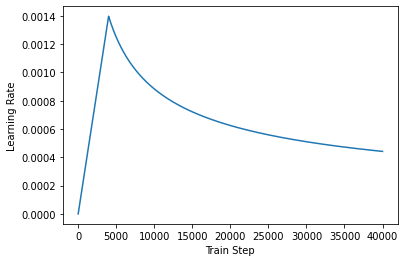

In [42]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### Define the loss function and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss. Use the cross-entropy loss function (`tf.keras.losses.SparseCategoricalCrossentropy`):

In [43]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [44]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

Set up the metrics:

In [45]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

### Checkpointing

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [46]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

With the Portuguese-English dataset, Portuguese is used as the input (`inp`) language and English is the target (`tar`) language.

The target is divided into target input (`tar_inp`) and real target (`tar_real`).

- `tar_inp` is passed as an input to the decoder.
- `tar_real` is that same input shifted by `1`: at each location in `tar_input`, `tar_real` contains the next token that should be predicted.

For example, `sentence = 'SOS A lion in the jungle is sleeping EOS'` becomes:

* `tar_inp =  'SOS A lion in the jungle is sleeping'`
* `tar_real = 'A lion in the jungle is sleeping EOS'`

A Transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing (like in the [text generation with RNNs](https://www.tensorflow.org/text/tutorials/text_generation) tutorial). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the model predicts each token, the self-attention mechanism allows it to look at the previous tokens in the input sequence to better predict the next token. As mentioned before, to prevent the model from peeking at the expected output the model uses a look-ahead mask.


### Train the Transformer

Define the training step:

In [47]:
train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# The `@tf.function` trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

You can now train the Transformer.

Note: This example model is trained for a few epochs (20) to keep training time reasonable for this tutorial. In Colab with a GPU, it may take around 150 seconds per epoch, or about 50 minutes in total to train the model. To speed things up, you can try reducing the number of `EPOCHS`, which may affect your accuracy.

In [48]:
EPOCHS = 10

In [49]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8768 Accuracy 0.0007
Epoch 1 Batch 50 Loss 8.8099 Accuracy 0.0027
Epoch 1 Batch 100 Loss 8.6988 Accuracy 0.0193
Epoch 1 Batch 150 Loss 8.5779 Accuracy 0.0299
Epoch 1 Batch 200 Loss 8.4285 Accuracy 0.0399
Epoch 1 Batch 250 Loss 8.2529 Accuracy 0.0479
Epoch 1 Batch 300 Loss 8.0576 Accuracy 0.0557
Epoch 1 Batch 350 Loss 7.8600 Accuracy 0.0631
Epoch 1 Batch 400 Loss 7.6723 Accuracy 0.0721
Epoch 1 Batch 450 Loss 7.5011 Accuracy 0.0821
Epoch 1 Batch 500 Loss 7.3464 Accuracy 0.0915
Epoch 1 Batch 550 Loss 7.2035 Accuracy 0.1002
Epoch 1 Batch 600 Loss 7.0705 Accuracy 0.1079
Epoch 1 Batch 650 Loss 6.9476 Accuracy 0.1151
Epoch 1 Batch 700 Loss 6.8325 Accuracy 0.1223
Epoch 1 Loss 6.8280 Accuracy 0.1226
Time taken for 1 epoch: 159.08 secs

Epoch 2 Batch 0 Loss 5.2365 Accuracy 0.2292
Epoch 2 Batch 50 Loss 5.2550 Accuracy 0.2213
Epoch 2 Batch 100 Loss 5.1868 Accuracy 0.2294
Epoch 2 Batch 150 Loss 5.1353 Accuracy 0.2349
Epoch 2 Batch 200 Loss 5.0897 Accuracy 0.2395
Epoch 2 Batch

## Run inference

You can now test the model by performing a translation. The following steps are used for inference:

* Encode the input sentence using the Portuguese tokenizer (`tokenizers.pt`). This is the encoder input.
* The decoder input is initialized to the `[START]` token.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Concatenate the predicted token to the decoder input and pass it to the decoder.
* In this approach, the decoder predicts the next token based on the previous tokens it predicted.

Note: The model is optimized for _efficient training_ and makes a next-token prediction for each token in the output simultaneously. This is redundant during inference, and only the last prediction is used.  This model can be made more efficient for inference if you only calculate the last prediction when running in inference mode (`training=False`).

Define the `Translator` class by subclassing `tf.Module`:

In [50]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.pt.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # Therefore, recalculate them outside the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

Note: This function uses an unrolled loop, not a dynamic loop. It generates `MAX_TOKENS` on every call. Refer to the [NMT with attention](nmt_with_attention.ipynb) tutorial for an example implementation with a dynamic loop, which can be much more efficient.

Create an instance of this `Translator` class, and try it out a few times:

In [51]:
translator = Translator(tokenizers, transformer)

In [52]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

Example 1:

In [53]:
sentence = 'este é um problema que temos que resolver.'
ground_truth = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


Example 2:

In [54]:
sentence = 'os meus vizinhos ouviram sobre esta ideia.'
ground_truth = 'and my neighboring homes heard about this idea .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors have heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


Example 3:

In [55]:
sentence = 'vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.'
ground_truth = "so i'll just share with you some stories very quickly of some magical things that have happened."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' ll be very quickly share with you a little bit of a bad news stories that happen .
Ground truth   : so i'll just share with you some stories very quickly of some magical things that have happened.


## Create attention plots

The `Translator` class you created in the previous section returns a dictionary of attention heatmaps you can use to visualize the internal working of the model.

For example:

In [56]:
sentence = 'este é o primeiro livro que eu fiz.'
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


Create a function that plots the attention when a token is generated:

In [57]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [58]:
head = 0
# Shape: `(batch=1, num_attention_heads, seq_len_q, seq_len_k)`.
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

These are the input (Portuguese) tokens:

In [59]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

And these are the output (English translation) tokens:

In [60]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

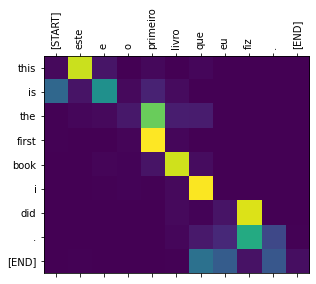

In [61]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [62]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

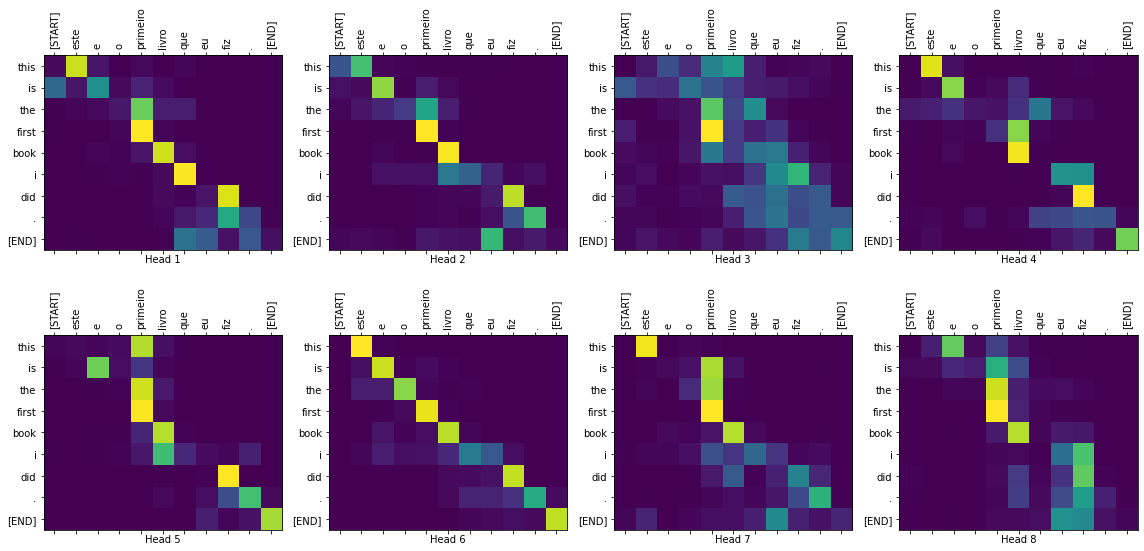

In [63]:
plot_attention_weights(sentence,
                       translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

The model does okay on unfamiliar words. Neither `'triceratops'` nor `'encyclopédia'` are in the input dataset, and the model almost learns to transliterate them even without a shared vocabulary. For example:

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about triburophords in encycloodia .
Ground truth   : I read about triceratops in the encyclopedia.


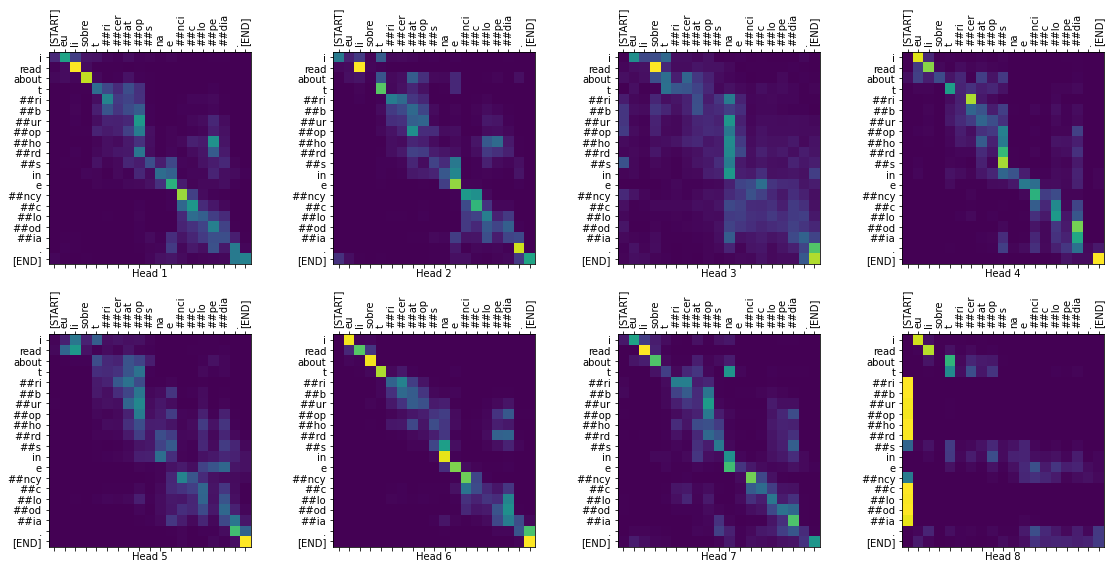

In [64]:
sentence = 'Eu li sobre triceratops na enciclopédia.'
ground_truth = 'I read about triceratops in the encyclopedia.'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

## Export the model

You have tested the model and the inference is working. Next, you can export it as a `tf.saved_model`. To learn about saving and loading a model in the SavedModel format, use [this guide](https://www.tensorflow.org/guide/saved_model).

Create a class called `ExportTranslator` by subclassing the `tf.Module` subclass with a `tf.function` on the `__call__` method:

In [65]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In the above `tf.function` only the output sentence is returned. Thanks to the [non-strict execution](https://tensorflow.org/guide/intro_to_graphs) in `tf.function` any unnecessary values are never computed.

Wrap `translator` in the newly created `ExportTranslator`:

In [66]:
translator = ExportTranslator(translator)

Since the model is decoding the predictions using `tf.argmax` the predictions are deterministic. The original model and one reloaded from its `SavedModel` should give identical predictions:

In [67]:
translator('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

In [68]:
tf.saved_model.save(translator, export_dir='translator')

In [69]:
reloaded = tf.saved_model.load('translator')

In [70]:
reloaded('este é o primeiro livro que eu fiz.').numpy()

b'this is the first book i did .'

## Conclusion

In this tutorial you learned about:

* The Transformers and their significance in machine learning
* Attention, self-attention and multi-head attention
* Positional encoding with embeddings
* The encoder-decoder architecture of the original Transformer
* Masking in self-attention
* How to put it all together to translate text

The downsides of this architecture are:

- For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.
- If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words.

If you want to practice, there are many things you could try with it. For example:

* Use a different dataset to train the Transformer.
* Create the "Base Transformer" or "Transformer XL" configurations from the original paper by changing the hyperparameters.
* Use the layers defined here to create an implementation of [BERT](https://arxiv.org/abs/1810.04805){:.external}.
* Implement beam search to get better predictions.

There are a wide variety of Transformer-based models, many of which improve upon the 2017 version of the original Transformer with encoder-decoder, encoder-only and decoder-only architectures.

Some of these models are covered in the following research publications:

* ["Efficient Transformers: a survey"](https://arxiv.org/abs/2009.06732){:.external} (Tay et al., 2022)
* ["Formal algorithms for Transformers"](https://arxiv.org/abs/2207.09238){:.external} (Phuong and Hutter, 2022)
* [T5 ("Exploring the limits of transfer learning with a unified text-to-text Transformer")](https://arxiv.org/abs/1910.10683){:.external} (Raffel et al., 2019)

You can learn more about other models in the following Google blog posts:

* [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html){:.external}
* [LaMDA](https://ai.googleblog.com/2022/01/lamda-towards-safe-grounded-and-high.html){:.external}
* [MUM](https://blog.google/products/search/introducing-mum/){:.external}
* [Reformer](https://ai.googleblog.com/2020/01/reformer-efficient-transformer.html){:.external}
* [BERT](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html){:.external}

If you're interested in studying how attention-based models have been applied in tasks outside of natural language processing, check out the following resources:

- Vision Transformer (ViT): [Transformers for image recognition at scale](https://ai.googleblog.com/2020/12/transformers-for-image-recognition-at.html){:.external}
- [Multi-task multitrack music transcription (MT3)](https://magenta.tensorflow.org/transcription-with-transformers){:.external} with a Transformer
- [Code generation with AlphaCode](https://www.deepmind.com/blog/competitive-programming-with-alphacode){:.external}
- [Reinforcement learning with multi-game decision Transformers](https://ai.googleblog.com/2022/07/training-generalist-agents-with-multi.html){:.external}
- [Protein structure prediction with AlphaFold](https://www.nature.com/articles/s41586-021-03819-2){:.external}
- [OptFormer: Towards universal hyperparameter optimization with Transformers](http://ai.googleblog.com/2022/08/optformer-towards-universal.html){:.external}
